# Agente de Entregas con Aprendizaje por Refuerzo
Estudiante: Verduguez Choquevillca Shariel Aylin (Ingeniería de Sistemas)

In [7]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import pygame

### ENTORNO DE ENTREGAS

Vehículo repartidor que debe entregar a N clientes.

Estado: [x, y, p1, ..., pN]

x, y: posición actual (0..10)

pi : 1 si el cliente i sigue pendiente, 0 si ya fue atendido.

Acción: índice del cliente a visitar (0..N-1).

Recompensa:

+10 por entrega correcta -distancia recorrida

-5 si intenta ir a un cliente ya atendido.

In [ ]:
class EntornoEntregas(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, clientes=None, deposito=None):
        super().__init__()

        self.clientes = np.array(
            clientes if clientes is not None else [
                [2, 7],
                [5, 5],
                [1, 4],
                [9, 9],
                [7, 4],
            ],
            dtype=np.float32,
        )

        self.deposito = np.array(
            deposito if deposito is not None else [1, 1],
            dtype=np.float32,
        )

        self.n_clientes = len(self.clientes)

        # ESPACIO DE ACCION
        self.action_space = spaces.Discrete(self.n_clientes)

        # ESTRUCTURA DEL ESTADO
        self.observation_space = spaces.Box(
            low=0,
            high=10,
            shape=(2 + self.n_clientes,),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # (CONSTRUCCION DEL ESTADO EN RESET)
        self.posicion = self.deposito.copy()

        self.pendientes = np.ones(self.n_clientes, dtype=np.float32)

        self.distancia_total = 0

        # Construimos el estado del entorno
        obs = np.concatenate([self.posicion, self.pendientes]).astype(np.float32)

        return obs, {}

    def step(self, accion):
        assert self.action_space.contains(accion), "Acción fuera de rango"

        if self.pendientes[accion] == 0:
            recompensa = -5
        else:
            destino = self.clientes[accion]

            distancia = float(np.linalg.norm(destino - self.posicion))

            self.distancia_total += distancia

            # Actualizamos la posición
            self.posicion = destino.copy()

            self.pendientes[accion] = 0

            recompensa = 10 - distancia

        terminado = bool(self.pendientes.sum() == 0)

        # Construimos el nuevo estado
        obs = np.concatenate([self.posicion, self.pendientes]).astype(np.float32)

        return obs, recompensa, terminado, False, {}

    def render(self):
        print(
            f"Posición: {self.posicion}, "
            f"Pendientes: {self.pendientes.astype(int)}, "
            f"Distancia total: {self.distancia_total:.2f}"
        )


### DISCRETIZACION ESTADO

Pasa de un estado continuo (x, y, pendientes...) a un estado discreto (ix, iy, máscara):

ix, iy: índices de una grilla (por ejemplo 0..10) para posición.

máscara: entero donde cada bit representa si un cliente está pendiente (1) o no (0).

In [ ]:
def codificar_estado(obs, bins_pos=11, max_grid=10):
    # extrae del vector de estado las dos primeras posiciones (x y)
    x, y = float(obs[0]), float(obs[1])

    # pendientes es el resto del vector (p1..pN)
    pendientes = np.array(obs[2:])

    # Función para discretizar un valor continuo 0..max_grid a 0..bins_pos-1
    def disc(v):
        # Escalamos el valor al rango de bins y truncamos hacia abajo
        idx = int(np.floor(v / max_grid * (bins_pos - 1)))
        return int(np.clip(idx, 0, bins_pos - 1))

    ix = disc(x)
    iy = disc(y)

    # máscara de pendientes (bit j = 1 si cliente j está pendiente)
    mascara = 0
    for j, p in enumerate(pendientes.astype(int)):
        if p == 1:
            mascara |= (1 << j)

    return ix, iy, mascara

### ENTRENAMIENTO Q-LEARNING

Ep     0 | Retorno:  12.29 | eps 1.00 | media(100)  12.29
Ep   200 | Retorno:  21.35 | eps 0.90 | media(100)  -0.95
Ep   400 | Retorno:  17.22 | eps 0.80 | media(100)   8.85
Ep   600 | Retorno:  19.01 | eps 0.70 | media(100)  11.93
Ep   800 | Retorno:  -9.09 | eps 0.60 | media(100)  13.58
Ep  1000 | Retorno:   7.22 | eps 0.50 | media(100)  19.01
Ep  1200 | Retorno:  25.59 | eps 0.40 | media(100)  22.89
Ep  1400 | Retorno:  32.61 | eps 0.30 | media(100)  25.22
Ep  1600 | Retorno:  24.19 | eps 0.20 | media(100)  27.59
Ep  1800 | Retorno:  32.61 | eps 0.10 | media(100)  30.14
Ep  2000 | Retorno:  23.78 | eps 0.05 | media(100)  31.20
Ep  2200 | Retorno:  32.61 | eps 0.05 | media(100)  31.63
Ep  2400 | Retorno:  24.96 | eps 0.05 | media(100)  31.67
Ep  2600 | Retorno:  23.68 | eps 0.05 | media(100)  31.20
Ep  2800 | Retorno:  32.61 | eps 0.05 | media(100)  31.62
Ep  3000 | Retorno:  23.78 | eps 0.05 | media(100)  31.35
Ep  3200 | Retorno:  32.61 | eps 0.05 | media(100)  31.28
Ep  3400 | Ret

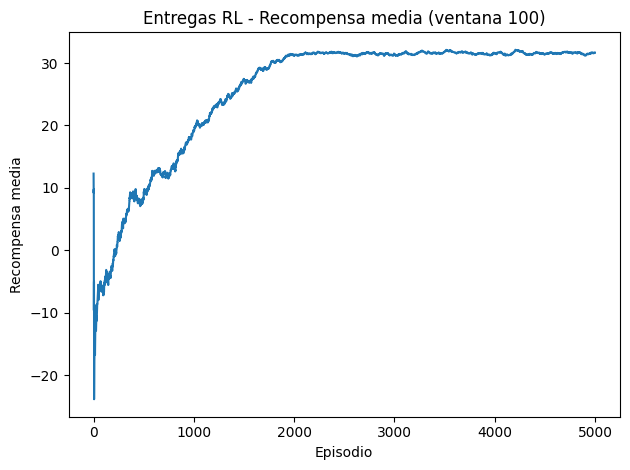

In [ ]:
def entrenar_qlearning(
    episodios=5000,
    model_path="entregas.pkl",
    plot_path="entregas.png",
    pos_bins=11,
    alpha=0.1, 
    gamma=0.99,
    eps_start=1.0, 
    eps_end=0.05, 
    eps_decay=0.0005,
):
    env = EntornoEntregas()

    n_acciones = env.action_space.n

    tam_mascara = 1 << env.n_clientes 

    # CREACION DE LA Q-TABLE
    Q = np.zeros((pos_bins, pos_bins, tam_mascara, n_acciones), dtype=np.float32)

    eps = eps_start

    recompensas = []

    mejor_media = -1e9

    # Bucle principal de episodios
    for ep in range(episodios):
        obs, _ = env.reset()

        # Obtenemos el estado discreto
        ix, iy, mascara = codificar_estado(obs, bins_pos=pos_bins)

        terminado = False  
        retorno = 0      

        # Bucle de interacción agente-entorno
        while not terminado:
            # Política ε-greedy
            if np.random.rand() < eps:
                accion = env.action_space.sample()
            else:
                accion = int(np.argmax(Q[ix, iy, mascara, :]))

            # Ejecutamos la acción en el entorno
            obs_n, r, terminado, _, _ = env.step(accion)

            # Codificamos el nuevo estado discreto
            nix, niy, nmascara = codificar_estado(obs_n, bins_pos=pos_bins)

            # ACTUALIZACION DE Q-LEARNING
            # Ecuacion de Bellman objetivo=r+γamax​Q(s′,a) (calcula el valor objetivo de Q-Learning)
            objetivo = r + (0 if terminado else gamma * np.max(Q[nix, niy, nmascara, :]))

            # Actualizamos Q con la regla estándar de Q-learning
            Q[ix, iy, mascara, accion] += alpha * (objetivo - Q[ix, iy, mascara, accion])

            ix, iy, mascara = nix, niy, nmascara

            retorno += r

        recompensas.append(retorno)

        eps = max(eps_end, eps - eps_decay)

        if ep % 200 == 0:
            # media de los últimos 100 episodios (o menos si todavía no hay 100)
            media100 = np.mean(recompensas[-100:]) if len(recompensas) >= 100 else np.mean(recompensas)
            print(f"Ep {ep:5d} | Retorno: {retorno:6.2f} | eps {eps:0.2f} | media(100) {media100:6.2f}")

            # Si esta media es mejor que la mejor hasta ahora, guardamos la Q-table
            if media100 > mejor_media and len(recompensas) >= 100:
                mejor_media = media100
                with open(model_path, "wb") as f:
                    pickle.dump(Q, f)

    # Al final del entrenamiento, guardamos el modelo final
    with open(model_path, "wb") as f:
        pickle.dump(Q, f)
    print(f"Modelo guardado en {model_path}")

    # ====================
    # Curva de aprendizaje
    # ====================
    # Es la recompensa media de los últimos hasta 100 episodios hasta el episodio k
    medias = [np.mean(recompensas[max(0, k - 99): k + 1]) for k in range(len(recompensas))]
    plt.figure()
    plt.plot(medias)
    plt.title("Entregas RL - Recompensa media (ventana 100)")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa media")
    plt.tight_layout()
    plt.savefig(plot_path)
    print(f"Gráfico guardado en {plot_path}")
    return Q, recompensas

def run(entrenar=True):
    if entrenar:
        entrenar_qlearning(
            episodios=5000,
            model_path="entregas.pkl",
            plot_path="entregas.png",
        )

if __name__ == "__main__":
    run(entrenar=True)


### VISUALIZACIÓN CON PYGAME

In [ ]:
def evaluar_con_pygame(
    model_path="entregas.pkl",
    pos_bins=11,
    episodios=1,
    fps=3,
):
    if not os.path.exists(model_path):
        print(f"No existe {model_path}. Primero entrena el modelo.")
        return

    with open(model_path, "rb") as f:
        Q = pickle.load(f)

    env = EntornoEntregas()

    pygame.init()

    ANCHO, ALTO = 600, 600

    pantalla = pygame.display.set_mode((ANCHO, ALTO))

    pygame.display.set_caption("Agente de Entregas - RL con pygame")

    reloj = pygame.time.Clock()

    # Función para pasar coordenadas del entorno [0..10] a pixeles [0..ANCHO/ALTO]
    def to_px(coord):
        x, y = coord
        # x se escala linealmente al ancho
        # y se invierte porque en pygame el eje y crece hacia abajo
        return int(x / 10 * ANCHO), int(ALTO - y / 10 * ALTO)

    COLOR_FONDO = (20, 20, 20)       
    COLOR_CLIENTE_PEND = (255, 80, 80) 
    COLOR_CLIENTE_OK = (80, 255, 80)   
    COLOR_DEPOT = (255, 215, 0)        
    COLOR_CARRO = (255, 255, 255)     

    # Repite la visualización tantas veces como diga episodios
    for _ in range(episodios):
        obs, _ = env.reset()
        terminado = False

        # Bucle principal del episodio
        while True:
            # Procesamos eventos (para poder cerrar la ventana)
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    return

            if not terminado:
                pos_ant = env.posicion.copy()

                # Decidimos la acción en modo greedy usando la Q-table
                ix, iy, mascara = codificar_estado(obs, bins_pos=pos_bins)
                accion = int(np.argmax(Q[ix, iy, mascara, :]))

                # Ejecutamos la acción en el entorno
                obs, r, terminado, _, _ = env.step(accion)

                pos_nueva = env.posicion.copy()

                pasos_anim = 20

                # Interpolamos posiciones entre pos_ant y pos_nueva
                xs = np.linspace(pos_ant[0], pos_nueva[0], pasos_anim)
                ys = np.linspace(pos_ant[1], pos_nueva[1], pasos_anim)

                # Bucle de animación del movimiento del carrito
                for i in range(pasos_anim):
                    # Volvemos a chequear eventos para poder cerrar en medio de la animación
                    for event in pygame.event.get():
                        if event.type == pygame.QUIT:
                            pygame.quit()
                            return

                    # Posición interpolada en este frame
                    x_interp, y_interp = xs[i], ys[i]

                    pantalla.fill(COLOR_FONDO)

                    dx, dy = to_px(env.deposito)
                    pygame.draw.circle(pantalla, COLOR_DEPOT, (dx, dy), 10)

                    for j, cliente in enumerate(env.clientes):
                        cx, cy = to_px(cliente)

                        # Si este cliente es la acción actual y aún no llegamos al último frame:
                        if j == accion and i < pasos_anim - 1:
                            pend = 1     
                        else:
                            pend = env.pendientes[j]

                        color = COLOR_CLIENTE_PEND if pend == 1 else COLOR_CLIENTE_OK

                        pygame.draw.circle(pantalla, color, (cx, cy), 8)

                    car_x, car_y = to_px((x_interp, y_interp))
                    CAR_W, CAR_H = 26, 18
                    pygame.draw.rect(
                        pantalla,
                        COLOR_CARRO,
                        (car_x - CAR_W // 2, car_y - CAR_H // 2, CAR_W, CAR_H),
                    )

                    pygame.display.flip()

                    reloj.tick(fps)

            else:
                pantalla.fill(COLOR_FONDO)

                dx, dy = to_px(env.deposito)
                pygame.draw.circle(pantalla, COLOR_DEPOT, (dx, dy), 10)

                # Todos los clientes (ya deberían estar verdes)
                for j, cliente in enumerate(env.clientes):
                    cx, cy = to_px(cliente)
                    color = COLOR_CLIENTE_PEND if env.pendientes[j] == 1 else COLOR_CLIENTE_OK
                    pygame.draw.circle(pantalla, color, (cx, cy), 8)

                # Carrito en su última posición
                car_x, car_y = to_px(env.posicion)
                CAR_W, CAR_H = 26, 18
                pygame.draw.rect(
                    pantalla,
                    COLOR_CARRO,
                    (car_x - CAR_W // 2, car_y - CAR_H // 2, CAR_W, CAR_H),
                )

                # Actualizamos pantalla
                pygame.display.flip()
                reloj.tick(fps)

            if terminado:
                pygame.time.wait(1500)
                break

    pygame.quit()

In [ ]:
def run(entrenar=True):
    if entrenar:
        entrenar_qlearning(
            episodios=5000,
            model_path="entregas.pkl",
            plot_path="entregas.png",
        )
    else:
        evaluar_con_pygame(
            model_path="entregas.pkl",
            pos_bins=11,
            episodios=1,
            fps=3,
        )

if __name__ == "__main__":
    run(entrenar=False)
